<a href="https://colab.research.google.com/github/FogtiIstvan/NephroNet/blob/main/NephroNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vese CT Felvételek Osztályozása Deep Learning Algoritmusok Felhasználásával
Fogti István, Dau Quang Phong, Gáspár Bálint

Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy házifeladataként készült.


## Adatkészlet letöltése
A feladathoz a kaggle-n található CT KIDNEY DATASET: "Normal-Cyst-Tumor and Stone" adatkészletet használtuk. Az adatkészlet 4 különböző osztályba tartozó címkézett CT felvételeket tartalmaz.

A letöltést tartalmazó cella futtatása során a kaggle API kér egy felhasználónevet illetve egy kulcsot, amely a kaggle felhasználói fiókba belépve érhető el. A könnyebb kiértékelhetőség érdekében alább található egy érvényes felhasználónév - kulcs pár:

 - username:"balintg99"

 - key:"9c065382b0262a56583ce88e2ff92eb7"


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: steveaoki
Your Kaggle Key: ··········


100%|██████████| 1.52G/1.52G [01:13<00:00, 22.2MB/s]


## Felhasznált könyvtárak importálása

A megoldás során a gyakorlatokon is használt numpy, illetve keras könyvtárak elemeit használtuk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

## Címkézés
A címkéket one-hot enkódoljuk illetve létrehozunk egy dictionaryt a későbbi dekódolhatóság érdekében


In [ ]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
data_dir = '/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
dataset=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                    label_mode = 'categorical', seed=123)



Found 12446 files belonging to 4 classes.


In [ ]:
label_to_class_name = dict(zip(range(len(dataset.class_names)), dataset.class_names))
print(label_to_class_name)
print(dataset.class_names)
print(len(dataset.class_names))
print(range(len(dataset.class_names)))

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}
['Cyst', 'Normal', 'Stone', 'Tumor']
4
range(0, 4)


In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = len(dataset.class_names)
indices = range(num_classes)
one_hot_indices = to_categorical(indices, num_classes=num_classes)
print(one_hot_indices)

label_to_class_name = {tuple(one_hot_indices[i]): dataset.class_names[i] for i in indices}
label_to_class_name

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


{(1.0, 0.0, 0.0, 0.0): 'Cyst',
 (0.0, 1.0, 0.0, 0.0): 'Normal',
 (0.0, 0.0, 1.0, 0.0): 'Stone',
 (0.0, 0.0, 0.0, 1.0): 'Tumor'}

## Adatkészlet felosztása
Az adatkészletet 80:10:10 arányban bontjuk fel train, validation és test adatokra

In [ ]:
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
test_size = int(0.1 * num_samples)
val_size = num_samples - train_size - test_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
val_dataset = dataset.skip(train_size + test_size)

shuffle_buffer_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size)
val_dataset = val_dataset.shuffle(buffer_size=shuffle_buffer_size)
test_dataset = test_dataset.shuffle(buffer_size=shuffle_buffer_size)

print(dataset)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


## Adatvizualizáció
A probléma megértése érdekében megjelenítünk néhány képet a címkéjükkel együtt.

Látható, hogy a felvételek több irányból készültek. A másik érdekesség, hogy a felvételek összetettek, több alakzatot tartalmaznak. Egészségügyi előképzettség nélkül ránézésre nem osztályozhatók a felvételek.

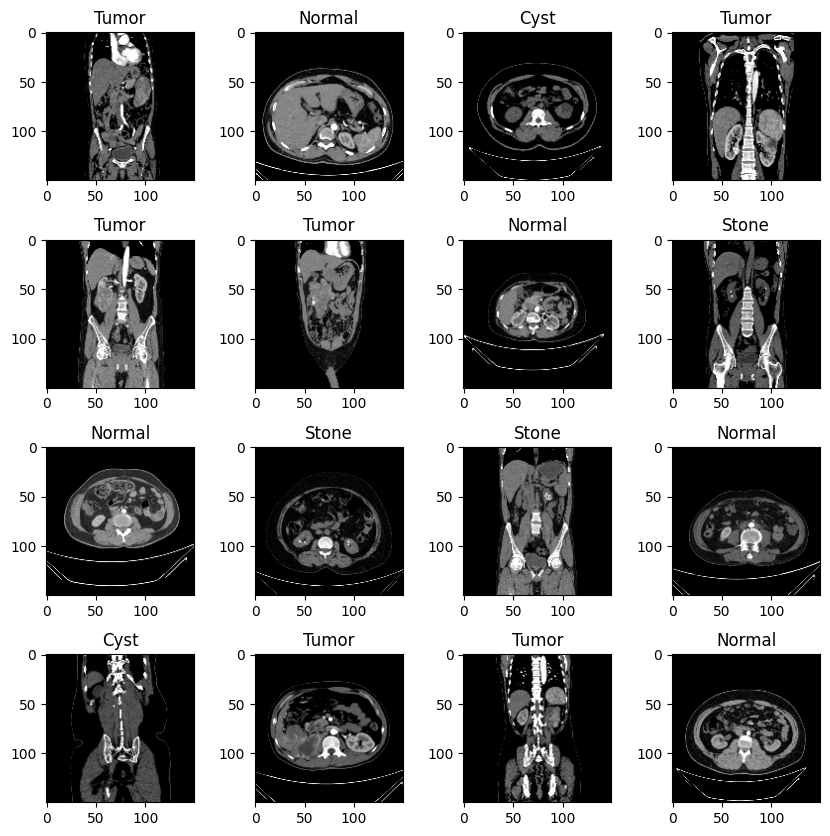

In [ ]:
data_iterator = train_dataset.as_numpy_iterator()
batch = data_iterator.next()

# Assuming label_to_class_name has keys as tuples of one-hot encoded values
# Convert one-hot encoded arrays to tuples for dictionary lookup
label_to_class_name = {tuple(key): value for key, value in label_to_class_name.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))

        # Convert the one-hot encoded label array to a tuple
        label_tuple = tuple(batch[1][index])

        # Use the tuple to get the class name from the dictionary
        ax[i, j].set_title(label_to_class_name[label_tuple])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

## Adatok előkészítése

A képeket korábban már átméreteztük egységes méretre, már csak normalizáljuk a pixelek értékeit illetve prefetch alkalmazásával gyorsítjuk a későbbi betöltést.

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print("-------------------")
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32, 4)
-------------------
(32, 150, 150, 3)
(32, 4)


In [ ]:
train_dataset=train_dataset.map(lambda x,y:(x/255,y))
val_dataset=val_dataset.map(lambda x,y:(x/255,y))
test_dataset=test_dataset.map(lambda x,y:(x/255,y))

print(train_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(image_batch.shape[1:4])

(150, 150, 3)


## Modell összeállítása

A feladat megoldásához konvolúciós neurális hálózatot
használunk, növekvő filterrel. Pooling rétegekkel csökkentjük a dimenzionalitást, miközben dropout rétegekkel csökkentjük a lehetőségek a túltanulásra. Az osztályozást fully connected rétegek végzik softmax aktivációval.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (5,5), activation = 'relu', input_shape=image_batch.shape[1:4]))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(32, (5,5), activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))

#model.add(Conv2D(64, (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 35, 35, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

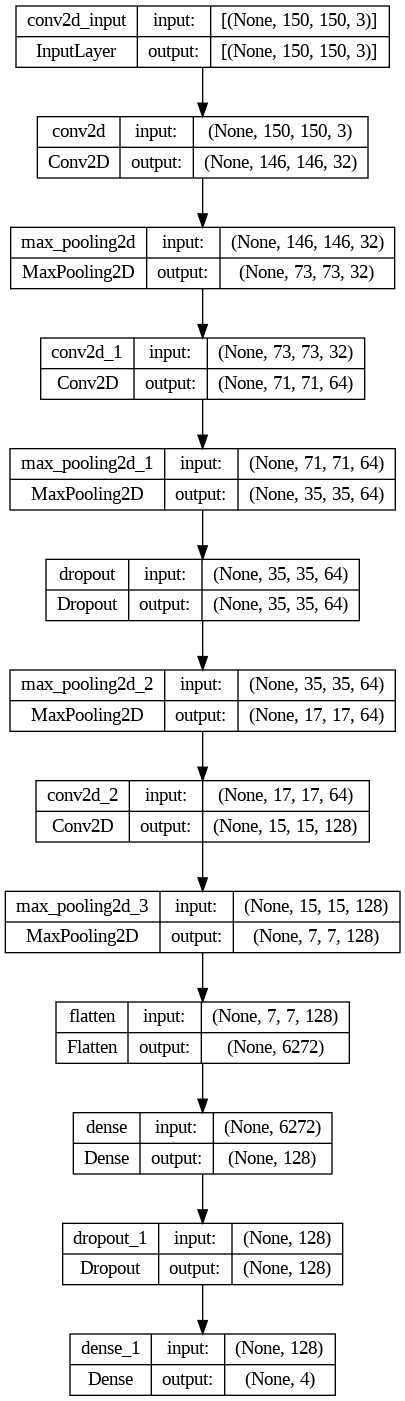

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes = True, show_layer_names = True)

## Tanítás
A tanítás futtatása előtt beállítjuk az early stoppingot, amely a validációs hibát figyeli minden epoch után. A legkisebb hibával rendelkező állapotot kimentjük.

In [ ]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
checkpointer=ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(train_dataset, epochs=30, batch_size = batch_size,
                            verbose=1, validation_data=test_dataset,
                            callbacks=[early_stopping, checkpointer, tb])

Epoch 1/30
311/311 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.8032
Epoch 1: val_loss improved from inf to 0.10250, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - 85s 163ms/step - loss: 0.5234 - accuracy: 0.8032 - val_loss: 0.1025 - val_accuracy: 0.9655
Epoch 2/30
311/311 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9669
Epoch 2: val_loss improved from 0.10250 to 0.01356, saving model to model.hdf5
311/311 [==============================] - 9s 30ms/step - loss: 0.0944 - accuracy: 0.9669 - val_loss: 0.0136 - val_accuracy: 0.9984
Epoch 3/30
311/311 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9846
Epoch 3: val_loss improved from 0.01356 to 0.00875, saving model to model.hdf5
311/311 [==============================] - 9s 29ms/step - loss: 0.0480 - accuracy: 0.9846 - val_loss: 0.0087 - val_accuracy: 0.9984
Epoch 4/30
311/311 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9935
Epoch 4: val_loss improved from 0.00875 to 0.00508, saving model to model.hdf5
311/311 [==============================] - 9s 29ms/step - loss: 0.0225 - accu

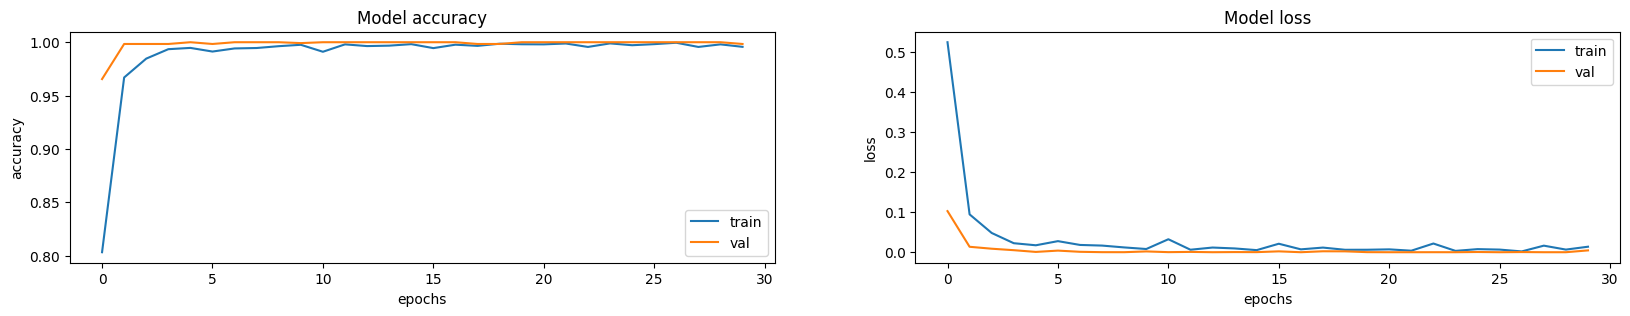

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(network_history.history[met])
    ax[i].plot(network_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Modell kiértékelése
A modellt több különböző módon is kiértékeltük független adatokon.

In [ ]:
model.evaluate(val_dataset)


40/40 [==============================] - 35s 21ms/step - loss: 5.9651e-04 - accuracy: 1.0000


[0.0005965136224403977, 1.0]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

y_pred = model.predict(val_dataset)
y_pred = np.argmax(y_pred,1)

true_labels = []
for _, labels in val_dataset:
    true_labels.extend(labels.numpy())
true_labels = np.argmax(np.array(true_labels), axis=1)

report = classification_report(true_labels, y_pred, target_names=label_to_class_name.values())
print(report)

40/40 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       392
      Normal       1.00      1.00      1.00       517
       Stone       1.00      1.00      1.00       127
       Tumor       1.00      1.00      1.00       242

    accuracy                           1.00      1278
   macro avg       1.00      1.00      1.00      1278
weighted avg       1.00      1.00      1.00      1278



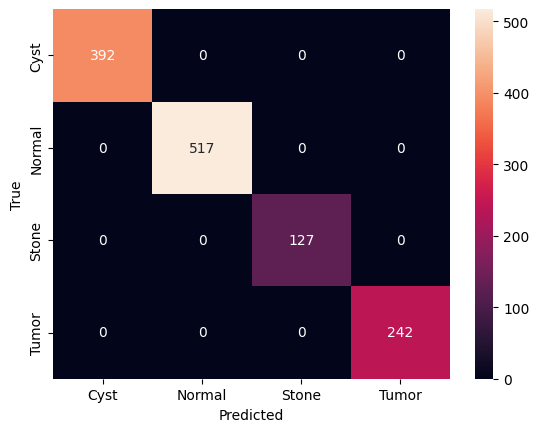

In [ ]:
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=label_to_class_name.values(), yticklabels=label_to_class_name.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
print("test accuracy: %g" %(accuracy_score(true_labels, y_pred)))
print("Precision", precision_score(true_labels, y_pred, average="macro"))
print("Recall", recall_score(true_labels, y_pred, average="macro"))
print("f1_score", f1_score(true_labels, y_pred, average="macro"))
print("\nConfusion matrix: ")
conf=confusion_matrix(true_labels, y_pred)
print(conf)

test accuracy: 1
Precision 1.0
Recall 1.0
f1_score 1.0

Confusion matrix: 
[[392   0   0   0]
 [  0 517   0   0]
 [  0   0 127   0]
 [  0   0   0 242]]
